In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,log_loss
from mlxtend.plotting import plot_decision_regions
import sys, math, os, json, re, random
import scipy.stats as stats
import seaborn as sns
import datetime as dt

from reticulum import AdaptiveBayesianReticulum

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df = pd.read_excel('RfqData.xlsx',sheet_name = 'Training RFQs')
oos = pd.read_excel('RfqData.xlsx',sheet_name = 'OOS RFQs')
competition = pd.read_excel('RfqData.xlsx',sheet_name = 'Competition RFQs')

In [9]:
#Maybe we can use this or feed in whole df???
bond_0_bid = df[(df['Bond'] == 'Bond_0')&(df['Side'] == 'Bid')]
bond_0_off = df[(df['Bond'] == 'Bond_0')&(df['Side'] == 'Offer')]
bond_1_bid = df[(df['Bond'] == 'Bond_0')&(df['Side'] == 'Bid')]
bond_0_off = df[(df['Bond'] == 'Bond_0')&(df['Side'] == 'Offer')]
bond_2_bid = df[(df['Bond'] == 'Bond_0')&(df['Side'] == 'Bid')]
bond_0_off = df[(df['Bond'] == 'Bond_0')&(df['Side'] == 'Offer')]

In [10]:
def plot(x_label,y_label,df):
    sns.scatterplot(x = x_label,y = y_label,data = df, hue = 'Traded')

In [11]:
def create_X_and_y(df):
    df['delta_from_mid'] = abs(df['MidPrice'] - df['QuotedPrice'])
    df['y'] = (df['Traded'] == 'DONE').astype(int)
    return df

In [12]:
def GNB(df):
    X = df[['Notional','delta_from_mid']]
    y = df['y']

    sc = StandardScaler() 
    sc_X = sc.fit_transform(X)
    
    clf = GaussianNB()
    clf.fit(X, y)
    ypred = clf.predict(X)
    
    # Confusion matrix
    print("Confusion Matrix")
    matrix = confusion_matrix(y, ypred)
    print(matrix)
    # Classification Report
    print("\nClassification Report")
    report = classification_report(y, ypred)
    print(report)
    # Accuracy of the model
    accuracy = accuracy_score(y, ypred)
    print('Gaussian NB Classification Accuracy of the model: {:.2f}%'.format(accuracy*100))
    
    plot_decision_regions(X.values, y.values, clf = clf, legend = 2)
    plt.title("Decision boundary using Naive Bayes")
    plt.xlabel("Notional")
    plt.ylabel("delta_from_mid")

In [13]:
df = create_X_and_y(df)

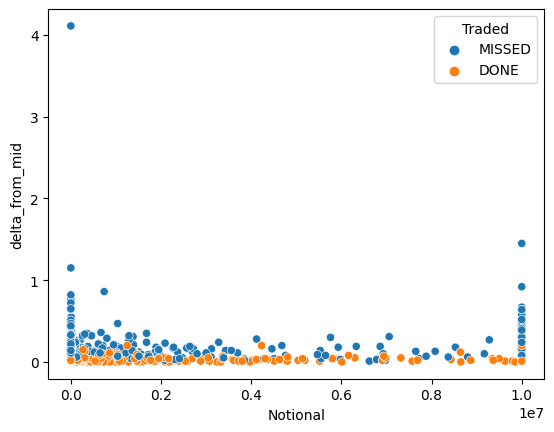

In [14]:
plot('Notional','delta_from_mid',df)

Confusion Matrix
[[ 343 1898]
 [ 338 2421]]

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.15      0.23      2241
           1       0.56      0.88      0.68      2759

    accuracy                           0.55      5000
   macro avg       0.53      0.52      0.46      5000
weighted avg       0.54      0.55      0.48      5000

Gaussian NB Classification Accuracy of the model: 55.28%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


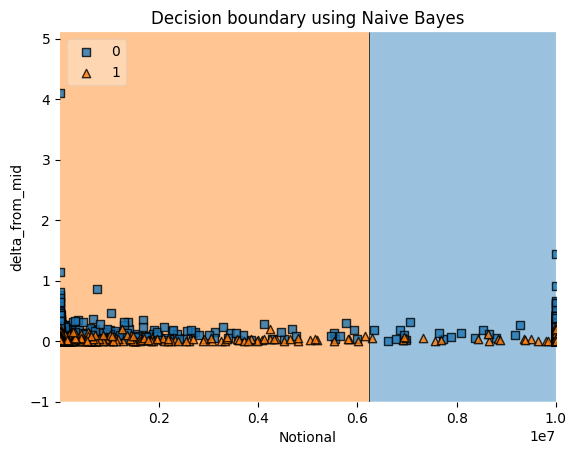

In [15]:
GNB(df)

In [23]:
def ABR(df):
    X = df[['Notional','delta_from_mid']]
    y = df['y']

    sc = StandardScaler() 
    sc_X = sc.fit_transform(X)
    
    model = AdaptiveBayesianReticulum(prior=(1, 1),pruning_factor=1.01,n_iter=100,
                                      learning_rate_init=0.1,n_gradient_descent_steps=1,
                                      initial_relative_stiffness=20)
    t0 = dt.datetime.utcnow()
    model.fit(X, y, verbose=False)
    t1 = dt.datetime.utcnow()
    #print('Model:')
    #print(model)
    #print(f'Training took {t1-t0}')
    
    ypred = model.predict(X)
    
    # Confusion matrix
    print("Confusion Matrix")
    matrix = confusion_matrix(y, ypred)
    print(matrix)
    # Classification Report
    print("\nClassification Report")
    report = classification_report(y, ypred)
    print(report)
    # Accuracy of the model
    accuracy = accuracy_score(y, ypred)
    print('Gaussian NB Classification Accuracy of the model: {:.2f}%'.format(accuracy*100))
    
    plot_decision_regions(X.values, y.values, clf = model, legend = 2)
    plt.title("Decision boundary using Naive Bayes")
    plt.xlabel("Notional")
    plt.ylabel("delta_from_mid")

Confusion Matrix
[[1928  313]
 [ 597 2162]]

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2241
           1       0.87      0.78      0.83      2759

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000

Gaussian NB Classification Accuracy of the model: 81.80%


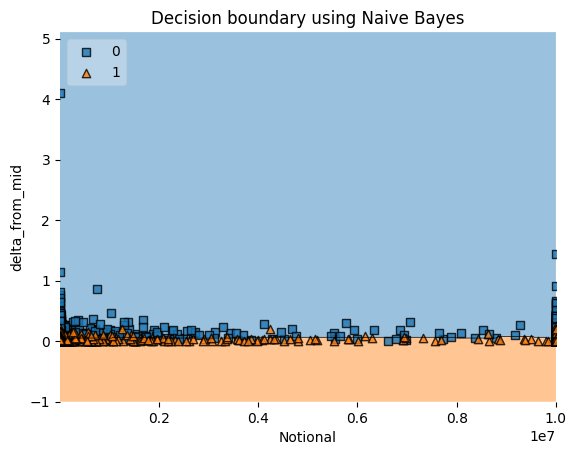

In [24]:
ABR(df)

In [25]:
def remove_quantile(n,col):
    q_low = df[col].quantile(n)
    q_hi  = df[col].quantile(1-n)
    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)] 
    return df_filtered

In [26]:
df = remove_quantile(0.01,'delta_from_mid')
df = remove_quantile(0.01,'Notional')

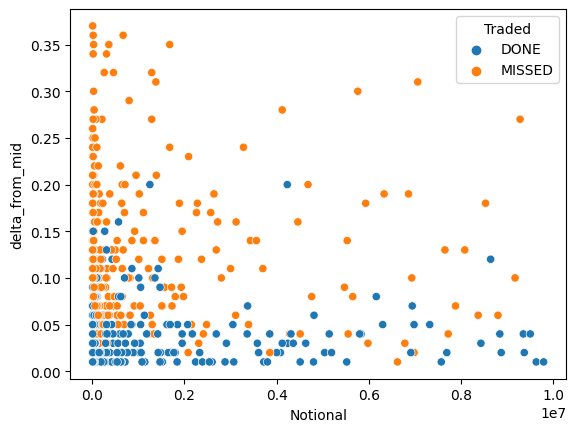

In [27]:
plot('Notional','delta_from_mid',df)

Confusion Matrix
[[287  49]
 [290  49]]

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       336
           1       0.50      0.14      0.22       339

    accuracy                           0.50       675
   macro avg       0.50      0.50      0.43       675
weighted avg       0.50      0.50      0.43       675

Gaussian NB Classification Accuracy of the model: 49.78%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


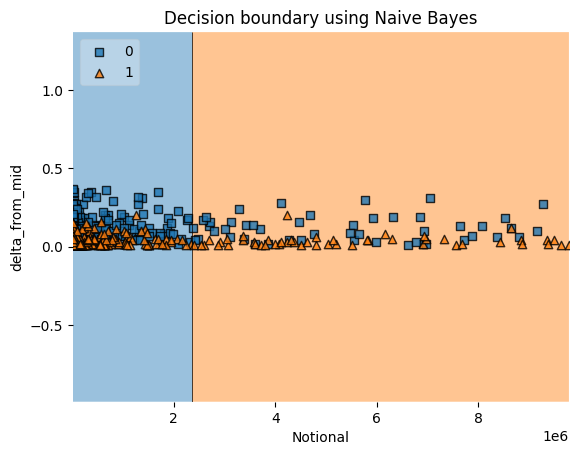

In [28]:
GNB(df)

Confusion Matrix
[[287  49]
 [ 79 260]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       336
           1       0.84      0.77      0.80       339

    accuracy                           0.81       675
   macro avg       0.81      0.81      0.81       675
weighted avg       0.81      0.81      0.81       675

Gaussian NB Classification Accuracy of the model: 81.04%


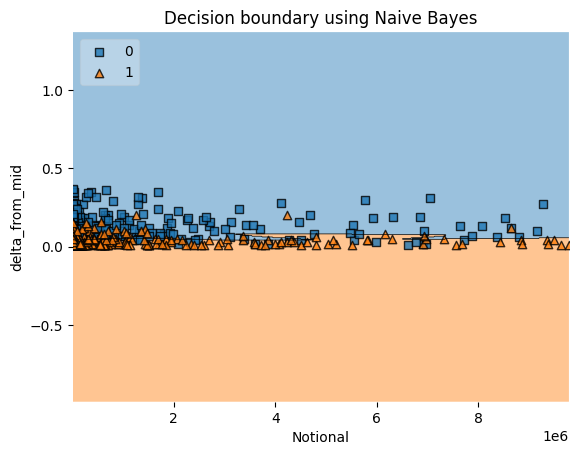

In [29]:
ABR(df)